# ИМПОРТЫ

In [20]:
from typing import TypedDict, Optional

from langgraph.graph import StateGraph, END
from langchain_community.tools import DuckDuckGoSearchRun
from IPython.display import Image, display
from openai import OpenAI

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm

# GRAPH

## LLM

In [5]:
client = OpenAI(
    base_url="http://localhost:11434/v1",
    api_key="ollama"
)

## Контейнер состояния

In [ ]:
class RelevanceState(TypedDict):
    query: str
    answer: str
    search_result: Optional[str]
    search_query: Optional[str]
    relevance: Optional[int]

## ПОИСК В ИНТЕРНЕТЕ

### TOOL

In [7]:
search_tool = DuckDuckGoSearchRun(timeout=60)  # 60 секунд

### Точка принятия решения

In [72]:
def evaluate_relevance(state: RelevanceState) -> RelevanceState:
    context = state.get("search_result", "")

    system_prompt = f"""
Ты - эксперт по анализу запросов пользователей для поиска мест на карте.
Твоя задача - определить соответствие запроса пользователя варианту ответа.

Шкала оценивания:

0 - Вариант ответа совершенно не удовлетворяет или противоречит запросу пользователя.
1 - Вариант ответа частично или полностью удовлетворяет запросу пользователя.
Также тебе доступен поиск в интернете. Например: для проверки информации о предложенном в варианте ответа заведении.


Запрос пользователя:
{state["query"]}

Дополнительный контекст из интернета (если есть):
{context}

Вариант ответа:
{state['answer']}

В ОТВЕТ НАПИШИ ТОЛЬКО ОДНУ ИЗ ОЦЕНОК ИЛИ ТЕКСТ ЗАПРОСА В ИНТЕРНЕТ!
"""

    response = client.chat.completions.create(
        model="gpt-oss:20b",
        messages=[
            {"role": "system", "content": system_prompt},
            #{"role": "user", "content": state["query"]}
        ]
    )

    try:
        state["relevance"] = int(response.choices[0].message.content.strip())
    except:
        state["relevance"] = -1
        state["search_query"] = response.choices[0].message.content.strip()
    return state


### Функция поиска

In [73]:
def web_search(state: RelevanceState) -> RelevanceState:
    query = state["search_query"]
    print('WEB query: ', query)
    try:
        result = search_tool.run(query)
    except Exception as e:
        print("Search failed:", e)
        result = ""
    state["search_result"] = result
    return state

## Сбор графа

In [74]:
graph = StateGraph(RelevanceState)

graph.add_node("evaluate", evaluate_relevance)
graph.add_node("search", web_search)

graph.set_entry_point("evaluate")

graph.add_conditional_edges(
    "evaluate",
    lambda s: s["relevance"]==-1,
    {True:"search", False:END}
)

graph.add_edge("search", "evaluate")
graph.add_edge("evaluate", END)

app = graph.compile()

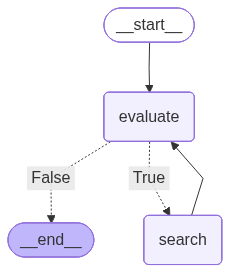

In [75]:
app

## Вычисляем тесты

In [76]:
train_data = pd.read_json(path_or_buf="content/data_final_for_dls_new.jsonl", lines=True)
eval_data = pd.read_json(path_or_buf="content/data_final_for_dls_eval_new.jsonl", lines=True)
eval_data = eval_data[eval_data["relevance"] != 0.1]
eval_data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance,reviews_summarized,relevance_new
0,сигары,"Москва, Дубравная улица, 34/29",Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,1263329400,None,1.0,"Организация занимается продажей табака, курите...",1.0
1,кальянная спб мероприятия,"Санкт-Петербург, Большой проспект Петроградско...",PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,228111266197,PioNero предлагает разнообразные блюда итальян...,0.0,"Организация PioNero — это кафе, бар и ресторан...",0.0
2,Эпиляция,"Московская область, Одинцово, улица Маршала Жу...",MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,1247255817,"Стоматологическая клиника, массажный салон и к...",1.0,"Организация занимается стоматологическими, кос...",1.0
4,стиральных машин,"Москва, улица Обручева, 34/63",М.Видео; M Video; M. Видео; M.Видео; Mvideo; М...,Магазин бытовой техники,1074529324,М.Видео предлагает широкий ассортимент бытовой...,1.0,Организация занимается продажей бытовой техник...,1.0
5,сеть быстрого питания,"Санкт-Петербург, 1-я Красноармейская улица, 15",Rostic's; KFC; Ресторан быстрого питания KFC,Быстрое питание,1219173871,Rostic's предлагает различные наборы быстрого ...,1.0,"Организация занимается быстрым питанием, предо...",1.0
...,...,...,...,...,...,...,...,...,...
561,наращивание ресниц,"Саратов, улица имени А.С. Пушкина, 1",Сила; Sila; Beauty brow; Студия бровей Beauty ...,Салон красоты,236976975812,Салон красоты «Сила» предлагает услуги по уход...,1.0,Организация «Сила» занимается предоставлением ...,1.0
565,игры,"Москва, Щёлковское шоссе, 79, корп. 1",YouPlay; YouPlay КиберКлуб,Компьютерный клуб,109673025161,YouPlay КиберКлуб предлагает услуги по игре на...,0.0,Организация занимается предоставлением услуг к...,0.0
566,домашний интернет в курске что подключить отзы...,"Курск, Садовая улица, 5",Цифровой канал; Digital Channel; DChannel; ЦК;...,Телекоммуникационная компания,1737991898,None,0.0,None,0.0
567,гостиница волгодонск сауна номер телефона,"Ростовская область, городской округ Волгодонск...",Поплавок; Poplavok,"База , дом отдыха",147783493467,"Предлагает размещение в различных типах жилья,...",0.0,Организация «Поплавок» предлагает услуги базы ...,0.0


In [77]:
predicted_relevance = []
for i, row in tqdm(eval_data.iterrows(), total=len(eval_data), desc="Processing rows"):
    answer = f"""
    Адрес: 
    {row['address']}

    Имя: 
    {row['name']}

    Рубрика: 
    {row['normalized_main_rubric_name_ru']}

    Описание: 
    {row['prices_summarized']}

    Отзывы:
    {row['reviews_summarized']}
    """
    result = app.invoke({
    "query": row['Text'],
    "answer": answer,
    "revelance":-1
    })
    try:
        predicted_relevance.append(float(result["relevance"]))
    except:
        print(result["relevance"])
        predicted_relevance.append(float(0))

eval_data['predicted_relevance'] = predicted_relevance

Processing rows:   0%|          | 0/500 [00:00<?, ?it/s]

WEB query:  Search the address and name.
WEB query:  Эпиляция
WEB query:  Россия, Республика Крым, городской округ Феодосия, село Береговое, гостевые дома
WEB query:  Вкусная еда
WEB query:  8. Лучшая итальянская кухня в городе
WEB query:  Считают аптеку хорошей.
WEB query:  
Search failed: query is mandatory.
WEB query:  
Search failed: query is mandatory.
WEB query:  
Search failed: query is mandatory.
WEB query:  We should output just the rating "1".1
WEB query:  6. Критикуют отсутствие некоторых справок
WEB query:  
Search failed: query is mandatory.
WEB query:  
Search failed: query is mandatory.


In [83]:
eval_data['predicted_relevance'].unique()

array([1., 0., 6., 2., 8.])

In [84]:
eval_data.loc[eval_data['predicted_relevance'] > 1, 'predicted_relevance'] = 1

In [85]:
eval_data['predicted_relevance'].unique()

array([1., 0.])

In [86]:
# 2. Приводим оба столбца к целочисленному типу (на всякий случай)
y_true = eval_data['relevance_new'].astype(int)
y_pred = eval_data['predicted_relevance'].astype(int)

# 3. Считаем метрики
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.6960
F1-score: 0.7305


# Итог

Применение агента не дало прироста в качестве. К сожалению, я не смог донести промптом внятный посыл модели что искать в интернете надо именно информацию об объекте, а не о запросе пользователя (я разные промпты пробовал). Тем не менее - граф работает, лишних действий теперь нет, да и запросы иногда нормальные проскакивают. Маленькая моделька иногда путается и дает оценку выше 1, но с применением модели постаршне - проблема уходит, но растут накладные расходы.

|Metrics|GPT OSS 20b|GPT OSS 120b|Agentic2:20b|
|-|-|-|-|
|Accuracy:| 0.7160| 0.7480| 0.6960|
|F1-score:| 0.7617| 0.7907| 0.7305|

In [88]:
eval_data.to_excel("agentic2/eval_data.xlsx")